# Towards predicting Emergent Abilities in Large Language Models

This is the code for our paper "Towards predicting Emergent Abilities in Large Language Models" (FMW @ CVPR'24).

Our aim is to explore whether “emergent abilities” can be predicted with scale for Large Language Models (LLMs) on some standard arithmetic tasks such as integer addition.

## Introduction

- Emergent abilities in Large Language Models (LLMs) seem to appear suddenly and unexpectedly with scale.
- In this work, we make progress toward being able to predict these emergence, for the case of accuracy in simple arithmetic tasks.
- This relies on two innovations: (1) realizing that accuracy follows a different (exponential) scaling law and (2) showing how we can overcome the so-called resolution problem with a
fixed-size dataset.

## Preliminaries

- Large Language Models (LLMs): auto-regressive models that predict the probability next word (token), given the previous ones.
- Scaling laws: the finding that the cross-entropy loss of next-token prediction in LLMs changes predictably with scale:

$$ \tag{1}
L = \frac{c}{N^a}
$$

where $L$ is the cross-entropy, $N$ the model size (number of parameters) and $a, c$ constants.

## Each metric follows a different scaling law

Our starting point is the seminal work of [(Shaffer et al., 2023)](https://arxiv.org/abs/2304.15004). They claim that some metrics like accuracy are in some sense ”bad”, since they are discontinuous. They propose e.g., changing accuracy to edit distance, which is more continuous and scales more predictably.

We counteract that the metric is a fundamental component of an ML task, and should not be changed. Instead, accuracy simply follows a different scaling law, an exponential one:

**Proposition 3.1**: Let $p$ be the probability of correct next token prediction, and $L$ the expected cross-entropy loss, as described before. Assuming that $p$ is i.i.d. (independent and identically distributed) among output tokens and the scaling law of eq. (1), we have the following relation:

$$ \tag{2}
acc \approx \exp(-c / N^a)^n 
$$

where $N$ is the model size, and $n$ the response length.

However, directly measuring eq. (2) runs into the resolution problem:
- Having $m$ data points, we can’t measure accuracies below $1/m$.
- This makes the performance of smaller models seem as 0, until we get a sudden jump at some specific size.

## Overcoming the resolution problem

We show that the resolution problem can be overcome, using only a fixed dataset size $m$. This relies on the fact that LLMs are probabilistic, and we can perform sampling.

When the correct answer(s) is known in advance, one can directly compute the LLM’s next token probabilities, and multiply them to obtain the probability of the final answer:

**Proposition 3.2**: Let $x$ be an input to an LLM $f_\theta$, and $y$ be the desired output. Then, the probability $p$ of $y$ as a completion of $x$ can be readily computed by $f_\theta$.

On the other hand, if we don’t know the correct answer in advance, but we can recognize it, we can use adaptive sampling: with that, we can measure arbitrarily low accuracies using only fixed data:

**Proposition 3.3**: Let $x$ be an input to an LLM $f_\theta$, and $p$ the probability that $f_\theta$ outputs a correct response. Sample $k$ answers, until a fixed number $s$ of successes are obtained; then, the estimate $p = s/k$ is a maximum likelihood estimate of the true probability $p$.

With that, we use the following algorithm to estimate the accuracy of an LLM:

![alg. 1](fig/alg1.png)

## Experiments

We work with the Pythia scaling suite [(Biderman, 2023)](https://arxiv.org/abs/2304.01373): this is a family of Transformer models trained on the PILE dataset, ranging from small sizes (14M parameters) up to large sizes (12B parameters). This makes Pythia an ideal testbet for studying LLM scaling.

We test the models on integer arithmetic tasks such as addition: 

**Prompt**: How much is 18 + 32? Answer: <br>
**Expected Answer**: 18 + 32 = 50

We construct a dataset of $m = 100$ random 2-digit addition cases, and use alg. 1 to evaluate the accuracy of different LLMs on it. We use default generation for the LLMs (with
temperature 0.7), and apply the sampling approach (Prop. 3.3), checking if the desired answer is contained in the LLM’s output.

Then, we can use the values to fit eq. (2) on the results. This can be done with linear regression, since we have:

$$ \tag{3}
acc = \exp(-c / N^a)^n \iff \ln(acc) = -n \frac{c}{N^a} \iff \\
\ln(- \ln(acc) ) = \ln(c n) - a \ln(N) \Rightarrow \\
\ln(- \ln(acc) ) = A \ln(N) + B
$$

with $A = -a, B = \ln(c n)$. 

We evaluate on the Pythia models of sizes 160M - 1.4B parameters, and plot their accuracy vs parameters size in a loglog vs log plot, as indicated by eq. (3). We also plot the regression line, as well as the performance of non-evaluated models of sizes 2.8B and 6.9B.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
# uncomment to run all evaluations from scratch. This will take several hours..
# !python 'src/pythia_models_v2'

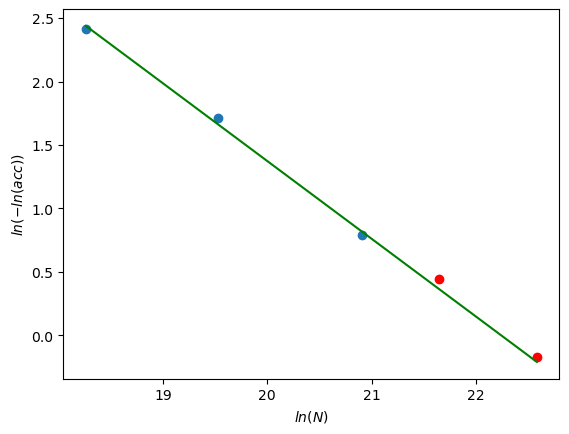

In [4]:
# load saved results
df = pd.read_csv('results/acc_vs_N_results.csv')
N_all = np.array( df['trainable_params'] )
acc_all = np.array( df['accs'] )

# use the models up to 1.4b for obtaining the curve, and the rest for scaling
Ns = N_all[:3]
accs = acc_all[:3]

Ns2 = N_all[3:]
accs2 = acc_all[3:]

# build the ln vs ln_ln plot
lnln_accs = np.log( -np.log( accs ) )
ln_Ns = np.log(Ns)

lnln_accs2 = np.log( -np.log( accs2 ) )
ln_Ns2 = np.log(Ns2)

x = ln_Ns
y = lnln_accs

x2 = ln_Ns2
y2 = lnln_accs2

x_all = np.concatenate((x, x2))
y_all = np.concatenate((y, y2))

# calculate the line of best fit
a, b = np.polyfit(x, y, 1)

# plot the scatter points
plt.scatter(x, y)
plt.scatter(x2, y2, c = 'r')

# plot the line of best fit
plt.plot(x_all, a*x_all + b, 'g')

# display
plt.xlabel('$ln(N)$')
plt.ylabel('$ln(-ln(acc))$')
plt.show()

Now translate the results back to the accuracy plot, and compare the extrapolation to the actual data (red points)

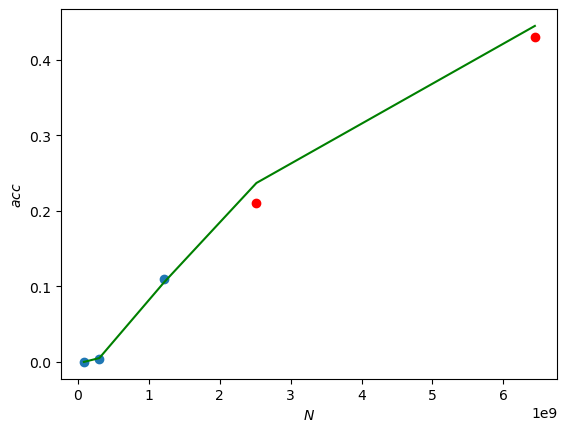

In [5]:
# standard plot
def calc_acc(N, A, B):
    x = np.log(N)
    y = A * x + b
    # y = ln(-ln(acc)), solve
    # so e^y = -ln(acc) => ln(acc) = -e^y => acc = exp(- e^y)
    acc = np.exp(- np.exp(y))
    return acc


Ns_all = np.concatenate((Ns, Ns2))
accs_all = np.concatenate((accs, accs2))

accs_calc = calc_acc(Ns_all, a, b)


# plot the scatter points
plt.scatter(Ns, accs)
plt.scatter(Ns2, accs2, c = 'r')

# plot the regression line
plt.plot(Ns_all, accs_calc, color = 'g')


# display
plt.xlabel('$N$')
plt.ylabel('$acc$')
plt.show()

Plot of $acc$ vs. $N$, along with the points for specific models. Models used in linear regression are plotted in blue, and not used ones in red.

Overall, the results indicate that emergence can be predicted in this setting. 

## Conclusion

- In this work, we try to address the puzzling phenomenon of emergent abilities in LLMs.
- In the case of accuracy, we come up with two solutions: (1) that accuracy follows a different scaling curve, and that (2) it can be accurately measured, overcoming the resolution
problem by sampling-based techniques.
- We find that our approach is able to predict the performance of larger LLMs on a simple arithemtic task relying only on measurements made on smaller models.
- Can we extend this results to further cases and metrics?